### データサイエンス特論プログラム課題第1回(クラスタリング)
- 作成日: 2022年7月15日
- 作成者: M1 203324 紺谷優志
- 内容: 20NewsGroupデータに対して２０クラスのクラスタリングを行い、Purity値とV-measureを評価する。

#### プログラムの詳細
テキストを固定長の文書ベクトルに変換する方法として、Sentence Transformerを採用した。モデルとして"all-MiniLM-L6-v2", "paraphrase-multilingual-mpnet-base-v2", "paraphrase-multilingual-MiniLM-L12-v2"を利用した。また、クラスタリング手法としては、sklearnライブラリに含まれるK-meansとGaussianMixtureを利用した。

テキストのベクトル化の際にGPU(CUDA Version: 11.4)を使用している。

In [1]:
import json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sentence_transformers import SentenceTransformer
from sentence_transformers import models
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics.cluster import v_measure_score

/home/kontani0930/.pyenv/versions/3.9.6/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#データセットの管理
class NewsGroupDataset():
    def __init__(self):
        # jsonファイルのロード
        # load JSON 20newsgroup data
        with open("newsgroups.json") as fd:
            data = json.load(fd)
        # content, target(=class ID), target_name(=newsgroup name)
        content = data['content']
        target = data['target']
        target_names = data['target_names']
        # get dictionary values for content, target, and target_names
        content_value = content.values()
        target_value = target.values()
        target_name_value = target_names.values()
        # extract lists for content, target, and target_names
        self.content_value_list = list(content_value) # メッセージテキスト本体
        self.target_value_list = list(target_value) # メッセージのカテゴリ ID
        self.target_namevalue_list = list(target_name_value)
        num_docs = 11314 # (=len(content.keys()) 

In [3]:
#SentenceTransformerでの埋め込みデータを保持
class SentenceTransformerModel:
    def __init__(self, model_num):
        #モデルの種類の選択
        if model_num ==0:
            name = "sentence-transformers/all-MiniLM-L6-v2"
        elif model_num==1:
            name ="sentence-transformers/paraphrase-mpnet-base-v2"
        else:
            name = "sentence-transformers/paraphrase-MiniLM-L12-v2"
        transformer = models.Transformer(name)
        pooling = models.Pooling(transformer.get_word_embedding_dimension(),pooling_mode_mean_tokens=True, pooling_mode_cls_token=False, pooling_mode_max_tokens=False)
        self.model = SentenceTransformer(modules=[transformer, pooling])

    #入力されたテキストからembeddingを生成
    def gen_embeddings(self,sentences,label):
        embeddings=self.model.encode(sentences)
        self.df=pd.DataFrame(embeddings)
        self.label=pd.Series(data=label)


In [4]:
class ClusteringModel:
    def __init__(self) -> None:
        pass
    
    #クラスタリングした内容を2次元のグラフにプロットする
    def plot(self,df,labels):
        X=StandardScaler().fit_transform(df)
        pca=PCA(n_components=2).fit(X)
        X_pc=pca.transform(X)
        df_pc=pd.DataFrame(X_pc)
        plt.figure(figsize=(14,10))
        plt.scatter(df_pc.iloc[:,0],df_pc.iloc[:,1],c=labels,s=50)
        plt.show()

    #purityを計算
    def calc_purity(self,df,true_label,pred_label):
        #Cross Tableを作成
        crosstab=pd.crosstab(true_label,pred_label)
        #Cross Tableを用いてpurity値を計算
        tmp=.0
        for i in range(len(crosstab.index.values)):
            tmp+=max(crosstab[:][i])
        purity=tmp/len(df.values)
        print("purity: ",purity)
    
    #V-measureを計算
    def calc_v_measure(self,true_label,pred_label):
        print("V-measure: ",v_measure_score(true_label,pred_label))

#k-meansでのクラスタリングを行うモデル
class KMeansModel(ClusteringModel):
    def __init__(self,cluster_num,df):
        self.df=df
        self.model=KMeans(n_clusters=cluster_num)
        self.model.fit(self.df.values)

    def plot(self):
        super().plot(self.df,self.model.labels_)
    
    def calc_purity(self,true_label):
        super().calc_purity(self.df,true_label,self.model.labels_)
    
    def calc_v_measure(self,true_label):
        super().calc_v_measure(true_label,self.model.labels_)

#Gaussian Mixtureでのクラスタリングを行うモデル
class GaussianMixtureModel(ClusteringModel):
    def __init__(self,cluster_num,df):
        self.df=df
        self.model=GaussianMixture(n_components=cluster_num)
        self.model.fit(self.df.values)
        self.pred_label=self.model.predict(self.df.values)

    def plot(self):
        super().plot(self.df,self.pred_label)
    
    def calc_purity(self,true_label):
        super().calc_purity(self.df,true_label,self.pred_label)
    
    def calc_v_measure(self,true_label):
        super().calc_v_measure(true_label,self.pred_label)
    

In [5]:
dataset=NewsGroupDataset()

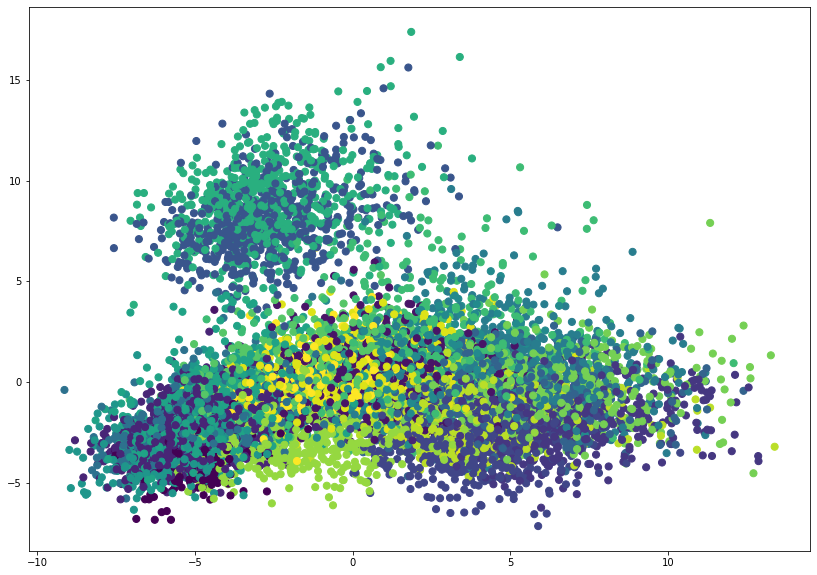

all-MiniLM-L6-v2 モデル
k-meansクラスタリングの結果
purity:  0.6103942018737847
V-measure:  0.6037756012772262
Gaussian Mixtureクラスタリングの結果
purity:  0.588386070355312
V-measure:  0.5924678367641398


In [9]:
transformer0=SentenceTransformerModel(0)
transformer0.gen_embeddings(dataset.content_value_list,dataset.target_value_list)
kmeans0=KMeansModel(20,transformer0.df)
kmeans0.plot()
print("all-MiniLM-L6-v2 モデル")
print("k-meansクラスタリングの結果")
kmeans0.calc_purity(transformer0.label)
kmeans0.calc_v_measure(transformer0.label)
Gaussian0=GaussianMixtureModel(20,transformer0.df)
print("Gaussian Mixtureクラスタリングの結果")
Gaussian0.calc_purity(transformer0.label)
Gaussian0.calc_v_measure(transformer0.label)

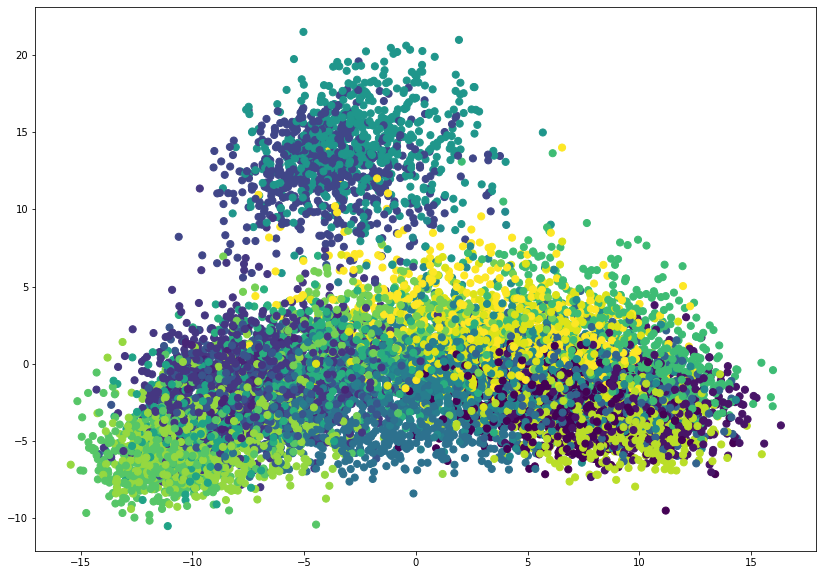

paraphrase-mpnet-base-v2 モデル
k-meansクラスタリングの結果
purity:  0.6514053385186495
V-measure:  0.6406214312798859
Gaussian Mixtureクラスタリングの結果
purity:  0.6196747392610924
V-measure:  0.628459918664743


In [10]:
transformer1=SentenceTransformerModel(1)
transformer1.gen_embeddings(dataset.content_value_list,dataset.target_value_list)
kmeans1=KMeansModel(20,transformer1.df)
kmeans1.plot()
print("paraphrase-mpnet-base-v2 モデル")
print("k-meansクラスタリングの結果")
kmeans1.calc_purity(transformer1.label)
kmeans1.calc_v_measure(transformer1.label)
Gaussian1=GaussianMixtureModel(20,transformer1.df)
print("Gaussian Mixtureクラスタリングの結果")
Gaussian1.calc_purity(transformer1.label)
Gaussian1.calc_v_measure(transformer1.label)

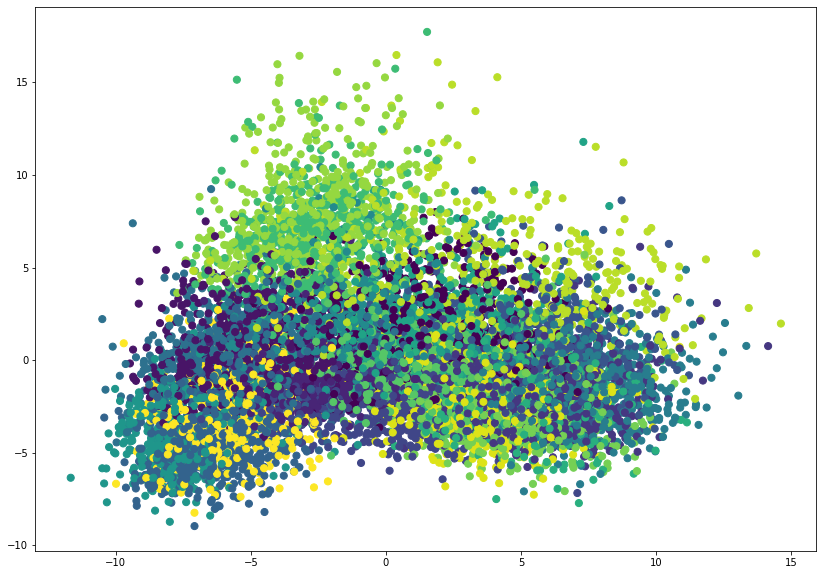

paraphrase-MiniLM-L12-v2 モデル
k-meansクラスタリングの結果
purity:  0.5881209121442461
V-measure:  0.577911623433159
Gaussian Mixtureクラスタリングの結果
purity:  0.5763655647869895
V-measure:  0.5810037953196295


In [12]:
transformer2=SentenceTransformerModel(2)
transformer2.gen_embeddings(dataset.content_value_list,dataset.target_value_list)
kmeans2=KMeansModel(20,transformer2.df)
kmeans2.plot()
print("paraphrase-MiniLM-L12-v2 モデル")
print("k-meansクラスタリングの結果")
kmeans2.calc_purity(transformer2.label)
kmeans2.calc_v_measure(transformer2.label)
Gaussian2=GaussianMixtureModel(20,transformer2.df)
print("Gaussian Mixtureクラスタリングの結果")
Gaussian2.calc_purity(transformer2.label)
Gaussian2.calc_v_measure(transformer2.label)

#### 考察

11313個のテキストを20のクラスタに分類するというタスクであることを考えると、0.6以上という結果はそれなりに高い水準であるように思える。Sentence Transformerのモデルが、テキスト中の単語・フレーズの意味をembeddingベクトルに正確に落とし込めていると言える。

クラスタリング手法については、多くの試行においてk-meansの方が混合ガウスモデルより高いpurityとV-measureを記録した。混合ガウスモデルはデータの分布をいくつかのガウス分布(正規分布)が重なり合わさってできたものであると仮定し、それぞれのクラスタがどのようなガウス分布で表せるかを推定するという手法である。そのため、データの広がりの大きさに差があるクラスタにも分散の大きなガウス分布を当てはめることで対応することができる。その反面、あるクラスタが別のクラスタを跨いで存在してしまう(どちらかといえばAという分布に近い位置にあるデータがBという分布にクラスタリングされてしまう)という、k-meansの分類方法ではあり得ない現象も起こりうる。そのような性質が影響して、今回の結果が得られたということが考えられる。一方で、k-meansでのスコアは試行する度にばらつきが大きく表れ、時には混合ガウスモデルを下回る結果になることもあった。その理由は、k-meansは最初の段階でランダムに重心点をとりクラスタリングを行うが、この時重心点どうしの初期値が近くなりすぎると局所最適解に陥り適切なクラスタリングができなくなる場合があるからである。そのため、実用面では、複数回試行を行って最も良いモデルを採用するなどの対策を講じる必要がある。